### import Library

In [1]:
import cv2
import torch
import kagglehub
import numpy as np
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Download Dataset

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia


### Transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

### import data

In [5]:
train_data = ImageFolder("/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train", transform=train_transforms)
test_data = ImageFolder("/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/test", transform=val_test_transforms)
val_data = ImageFolder("/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/val", transform=val_test_transforms)

### Loaders

In [6]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

### select device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Class Weight

In [8]:
class_counts = Counter(train_data.targets)
num_samples = len(train_data.targets)

class_weights = [
    num_samples / (class_counts[i] * len(class_counts)) 
    for i in class_counts 
]

class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

### Model

In [9]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


### Early Stopping Setup

In [10]:
patience = 3 
best_val_loss = float('inf')
counter = 0
epochs = 20

### Training Loop + EarlyStopping

In [11]:
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch: {epoch} | Train_Loss: {train_loss} | Val_Loss: {val_loss} ")

    # ------Early Soping---------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0 
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved")
        
    else:
        counter += 1
        print(f"No improvement {counter} / {patience}")

    if counter >= patience:
        print("Early Stoping Treggered")
        break

Epoch: 0 | Train_Loss: 0.13576568439717124 | Val_Loss: 0.33922502398490906 
✅ Best model saved
Epoch: 1 | Train_Loss: 0.08718341098172716 | Val_Loss: 0.17852775752544403 
✅ Best model saved
Epoch: 2 | Train_Loss: 0.05986653254196002 | Val_Loss: 0.30799999833106995 
No improvement 1 / 3
Epoch: 3 | Train_Loss: 0.04317078432011092 | Val_Loss: 1.157533884048462 
No improvement 2 / 3
Epoch: 4 | Train_Loss: 0.04196782415215657 | Val_Loss: 0.566511869430542 
No improvement 3 / 3
Early Stoping Treggered


### Evaluation

In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        _, predicted = torch.max(output, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

In [13]:
print("\n===== Test Metrics =====")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


===== Test Metrics =====
Accuracy : 85.58%
Precision: 0.8151
Recall   : 0.9949
F1 Score : 0.8961


In [14]:
cm = confusion_matrix(all_labels, all_preds)

<Axes: >

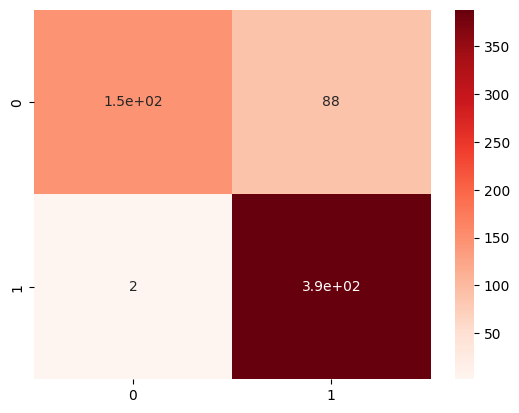

In [15]:
sns.heatmap(cm, cmap='Reds', annot=True)

### Grad_CAM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.4308496].


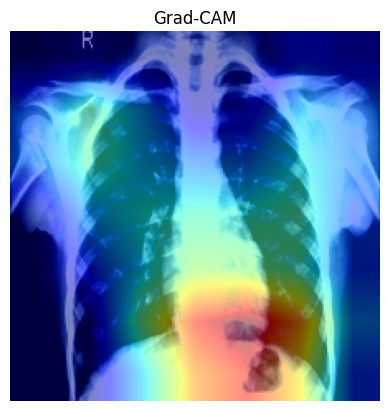

In [16]:
target_layer = model.layer4
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

image, label = test_data[0]
input_tensor = image.unsqueeze(0).to(device)

model.zero_grad()
output = model(input_tensor)
pred_class = output.argmax(dim=1)
output[0, pred_class].backward()

grad = gradients[0].cpu().detach().numpy()[0]
act = activations[0].cpu().detach().numpy()[0]

weights = np.mean(grad, axis=(1,2))
cam = np.zeros(act.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * act[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224,224))
cam = cam / cam.max()

plt.imshow(image.permute(1,2,0))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()